In [23]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
from time import time
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
# Initial Variables 
MIN_IMGS_IN_CLASS=500;
image_size = 50;

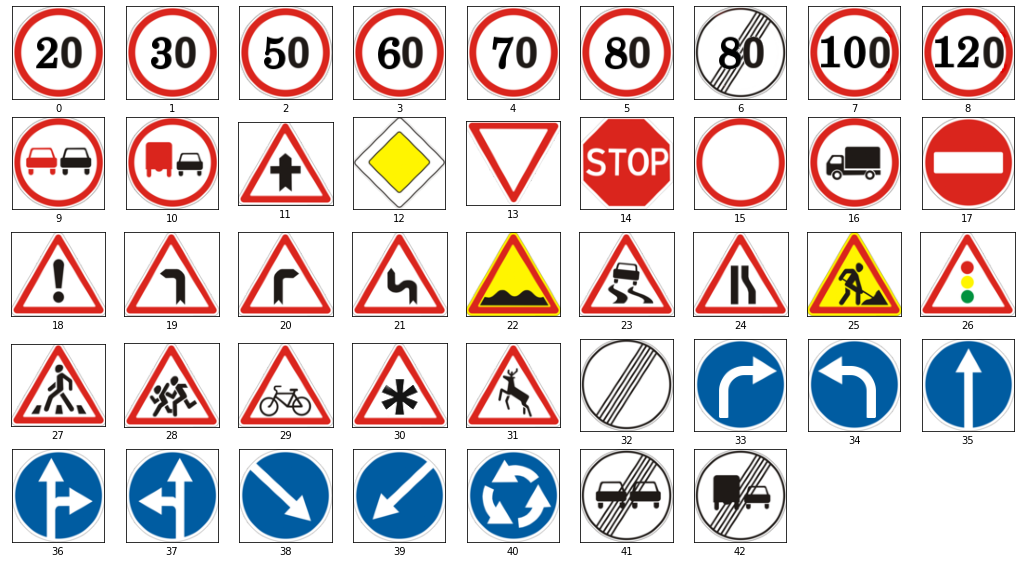

In [6]:
# Here is the meta files on the 43 seperate traffic sign classes we are learning to identify 
plt.figure(figsize=(18, 18))
for i in range (0,43):
    plt.subplot(9,9,i+1)
    plt.xticks([])
    plt.yticks([])
    path = "./Meta/{0}.png".format(i)
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(i)

In [103]:
train_image_data = pd.read_csv('Train.csv')
train_image_data.describe
train_image_data.value_counts().to_dict()

{(243, 225, 20, 20, 223, 205, 25, 'Train/25/00025_00003_00029.png'): 1,
 (37, 38, 5, 6, 31, 33, 9, 'Train/9/00009_00009_00009.png'): 1,
 (37, 38, 5, 6, 32, 33, 1, 'Train/1/00001_00004_00020.png'): 1,
 (37, 38, 5, 6, 32, 33, 0, 'Train/0/00000_00000_00012.png'): 1,
 (37, 38, 5, 6, 32, 32, 9, 'Train/9/00009_00018_00017.png'): 1,
 (37, 38, 5, 6, 32, 32, 2, 'Train/2/00002_00009_00000.png'): 1,
 (37, 38, 5, 6, 32, 32, 1, 'Train/1/00001_00059_00005.png'): 1,
 (37, 38, 5, 6, 31, 33, 31, 'Train/31/00031_00003_00002.png'): 1,
 (37, 38, 5, 6, 31, 33, 17, 'Train/17/00017_00023_00016.png'): 1,
 (37, 38, 5, 6, 31, 33, 7, 'Train/7/00007_00026_00016.png'): 1,
 (37, 38, 5, 6, 32, 33, 4, 'Train/4/00004_00037_00012.png'): 1,
 (37, 38, 5, 6, 31, 33, 3, 'Train/3/00003_00016_00010.png'): 1,
 (37, 38, 5, 6, 31, 33, 1, 'Train/1/00001_00058_00009.png'): 1,
 (37, 38, 5, 6, 31, 33, 1, 'Train/1/00001_00022_00007.png'): 1,
 (37, 38, 5, 6, 31, 32, 35, 'Train/35/00035_00013_00013.png'): 1,
 (37, 38, 5, 6, 31, 32, 12

<AxesSubplot:>

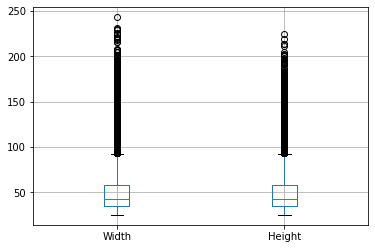

In [14]:
train_image_data.boxplot(['Width', 'Height'])

<AxesSubplot:title={'center':'Number of labelled images in each category'}, ylabel='ClassId'>

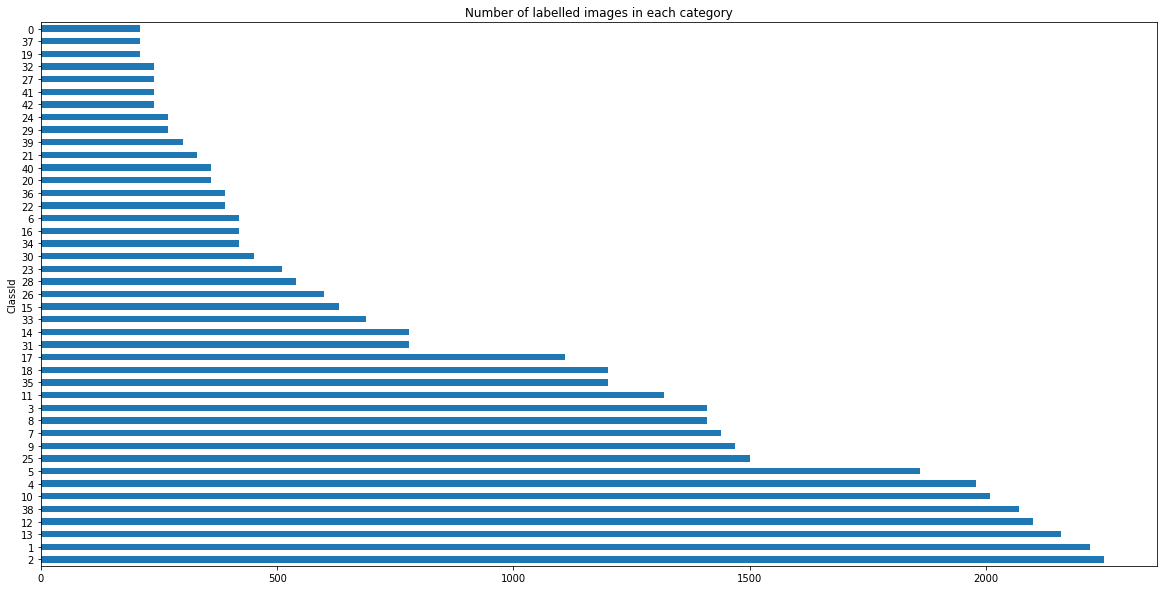

In [50]:
train_image_data.value_counts('ClassId').plot(kind='barh', figsize=(20, 10), ylabel='CountClassId', title='Number of labelled images in each category')

# Loading Data

In [129]:
def preprocess(image, out_side):
    height, width = image.shape[:2]
    scale = out_side / max(height, width)
    dx = (out_side - scale * width) / 2
    dy = (out_side - scale * height) / 2
    trans = np.array([[scale, 0, dx], [0, scale, dy]], dtype=np.float32)
    image = cv2.warpAffine(image, trans, (out_side, out_side), flags=cv2.INTER_AREA)
    image = cv2.resize(image, (out_side, out_side))
    return image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(path, out_side):
    images = []
    labels = []
    for folder in os.listdir(os.path.join(path, 'Train')):
        cur_path = os.path.join(path, 'Train', folder)
        for file_name in os.listdir(cur_path):
            image = cv2.imread(os.path.join(cur_path, file_name))
            images.append(preprocess(image, out_side))
            labels.append(int(folder))

    return mixing(images, labels)

def load_test(path, out_side):
    images = []
    labels = []
    with open(os.path.join(path, 'Test.csv'), 'r') as f:
        reader = csv.reader(f)
        for rows in reader:
            name = rows[7]
            if (name == 'Path'):
                continue
            image = cv2.imread(os.path.join(path, rows[7]))
            images.append(preprocess(image, out_side))
            labels.append(int(rows[6]))

    return mixing(images, labels)

In [151]:
train_images, train_labels = load_train("./", image_size)

In [152]:
print(train_images.shape)
print(train_labels.shape)

(39209, 50, 50, 3)
(39209,)


Once we have the training data loaded, we can preview them 

In [153]:
def preview(images, labels):
    plt.figure(figsize=(16, 16))
    for c in range(len(np.unique(labels))):
        i = random.choice(np.where(labels == c)[0])
        plt.subplot(10, 10, c+1)
        plt.axis('off')
        plt.title('class: {}'.format(c))
        plt.imshow(images[i])

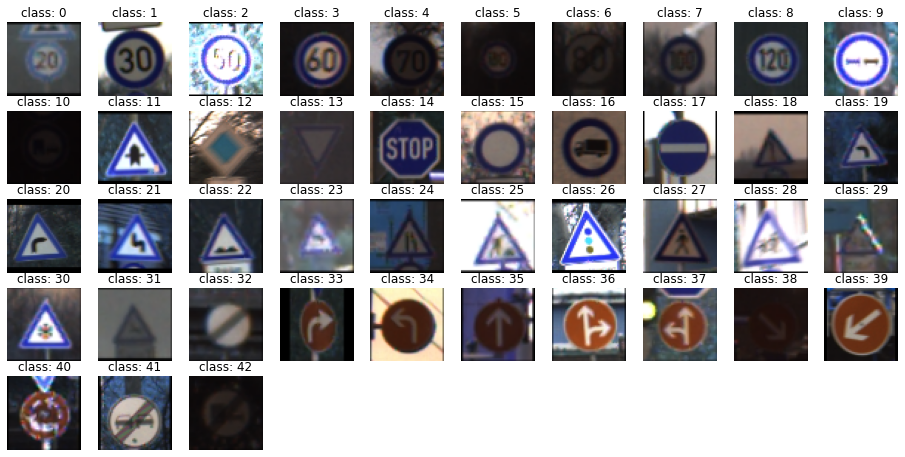

In [154]:
preview(train_images, train_labels)

In [155]:
# Code from here
# https://medium.com/ai-in-plain-english/traffic-sign-recognition-problem-with-gtsrb-python-and-keras-21782b7b3520
def augment_imgs(imgs, p):
    """
    Performs a set of augmentations with with a probability p
    """
    from imgaug import augmenters as iaa
    augs =  iaa.SomeOf((2, 4),
          [
              iaa.Crop(px=(0, 4)), # crop images from each side by 0 to 4px (randomly chosen)
              iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
              iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
              iaa.Affine(rotate=(-45, 45)), # rotate by -45 to +45 degrees)
              iaa.Affine(shear=(-10, 10)) # shear by -10 to +10 degrees
          ])
    
    seq = iaa.Sequential([iaa.Sometimes(p, augs)])
    res = seq.augment_images(imgs)
    return res

def count_images_in_classes(lbls):
    dct = {}
    for i in lbls:
        if i in dct:
            dct[i] += 1
        else:
            dct[i] = 1
    return dct

In [156]:
def augmentation(imgs, lbls):
    classes = train_image_data.value_counts('ClassId').to_dict()
    for i in range(len(classes)):
        if (classes[i] < MIN_IMGS_IN_CLASS):
            # Number of samples to be added
            add_num = MIN_IMGS_IN_CLASS - classes[i]
            imgs_for_augm = []
            lbls_for_augm = []
            for j in range(add_num):
                im_index = random.choice(np.where(lbls == i)[0])
                imgs_for_augm.append(imgs[im_index])
                lbls_for_augm.append(lbls[im_index])
            augmented_class = augment_imgs(imgs_for_augm, 1)
            augmented_class_np = np.array(augmented_class)
            augmented_lbls_np = np.array(lbls_for_augm)
            imgs = np.concatenate((imgs, augmented_class_np), axis=0)
            lbls = np.concatenate((lbls, augmented_lbls_np), axis=0)
    return (imgs, lbls)

In [157]:
train_images, train_labels = augmentation(train_images, train_labels)

In [158]:
print(train_images.shape)
print(train_labels.shape)

(42739, 50, 50, 3)
(42739,)


<AxesSubplot:title={'center':'Number of labelled images in each category'}, ylabel='CountClassId'>

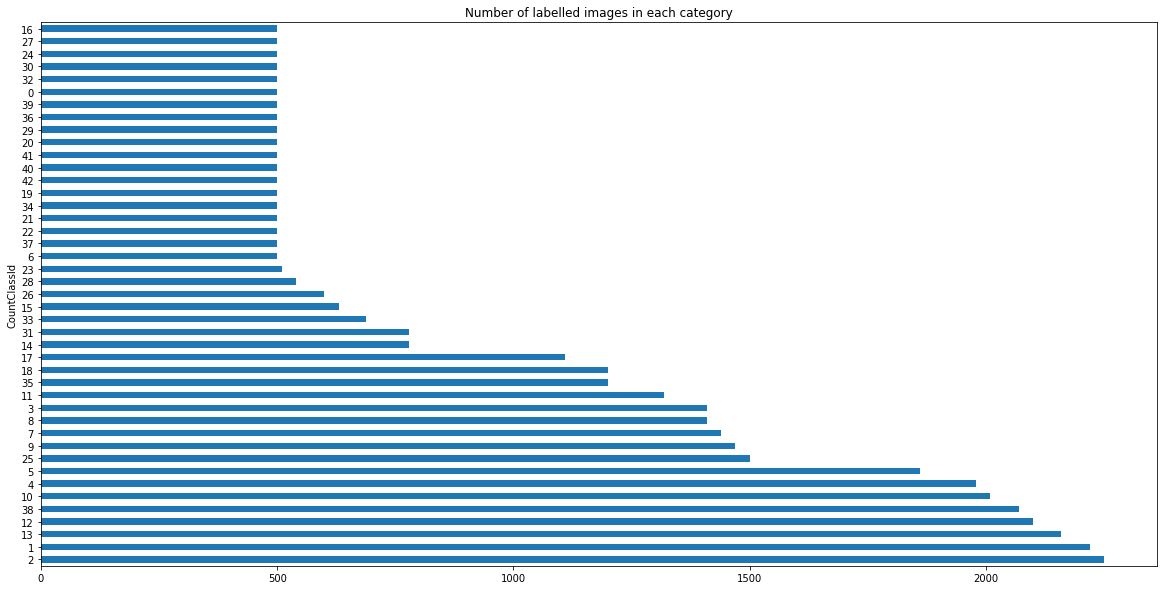

In [135]:
labels = pd.Series(count_images_in_classes(train_labels))
labels = labels.sort_values(ascending=False)
labels.plot(kind='barh',figsize=(20, 10), ylabel='CountClassId', title='Number of labelled images in each category')

Loading:  1.6393208503723145


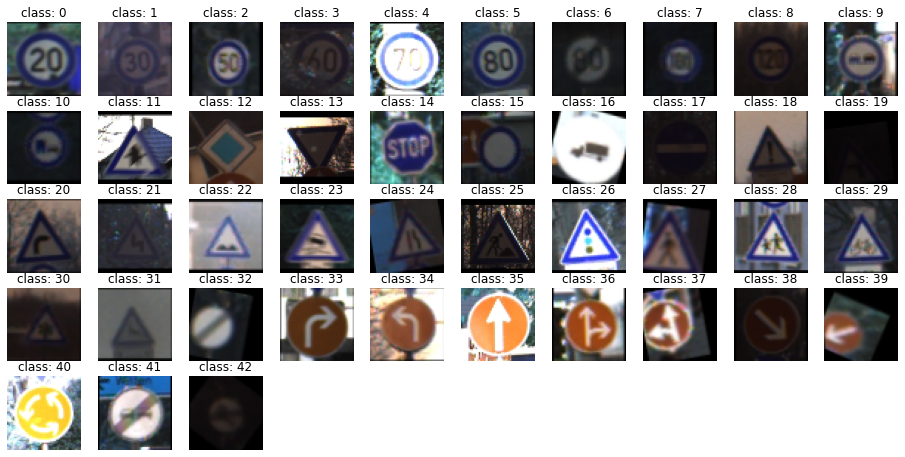

In [159]:
start = time()

from skimage.color import rgb2gray

train_images = train_images.astype('float32') / 255.
# train_images_test = rgb2gray(train_images)

train_labels_cat = utils.to_categorical(train_labels, 43)

preview(train_images, train_labels)
print('Loading: ', time() - start)

In [174]:
classes = 43
batch = 128
epochs = 2
learning_rate = 0.0001

def results(model):
  adam = Adam(lr=learning_rate)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  start = time()
  history = model.fit(train_images, train_labels_cat, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1)
  train_time = time() - start

  model.summary()

  plt.figure(figsize=(12, 12))
  plt.subplot(3, 2, 1)
  plt.plot(history.history['accuracy'], label = 'train_accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.subplot(3, 2, 2)
  plt.plot(history.history['loss'], label = 'train_loss')
  plt.plot(history.history['val_loss'], label = 'val_loss')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

In [175]:
print(train_images.shape)
print(train_labels_cat.shape)

(42739, 50, 50, 3)
(42739, 43)


Epoch 1/2
268/268 [==============================] - 1004s 4s/step - loss: 0.4661 - accuracy: 0.8812 - val_loss: 0.6697 - val_accuracy: 0.8607
Epoch 2/2
268/268 [==============================] - 958s 4s/step - loss: 0.0205 - accuracy: 0.9949 - val_loss: 0.5362 - val_accuracy: 0.8683
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 1, 512)         2048      
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_9 (Dense)              (Non

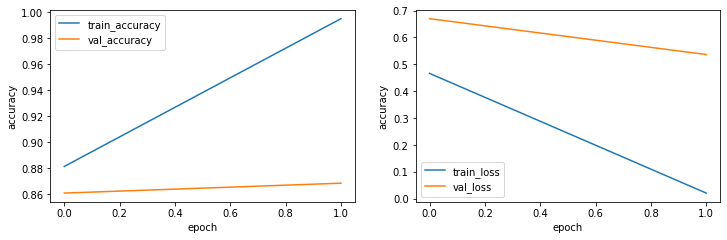

In [176]:
model = Sequential()
model.add(VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(43, activation='softmax'))

results(model)

## Testing the model

In [163]:
test_image_data = pd.read_csv('Test.csv')

In [164]:
test_images, test_labels = load_test("./", image_size)

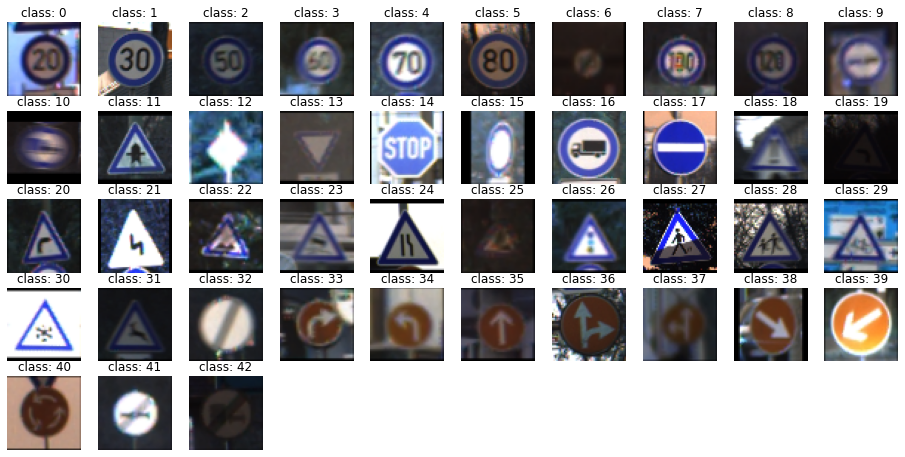

In [165]:
preview(test_images, test_labels)

In [168]:
test_images = test_images.astype('float32') / 255.
# test_images = rgb2gray(train_images)
test_labels = utils.to_categorical(test_labels, 43)
print('Loading: ', time() - start)

Loading:  2291.500739097595


In [177]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_time = time() - start

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)
print('Test time: ', test_time)

395/395 [==============================] - 66s 166ms/step - loss: 0.1212 - accuracy: 0.9636
Test accuracy: 0.9635787606239319
Test loss: 0.12123327702283859
Test time:  5718.157373905182
